In [11]:
%matplotlib inline
import sys
sys.path.append("/Users/edwardlrichards/compAcoustics") 
sys.path.append("/Users/edwardlrichards/swellEx") 

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from itertools import islice
import datetime as d

import swellEx_env
import loadCSDM as cm
from matchedField import MFP

from normalMode import Chinook
from beamformers import bartlet
from beamformers import wnc_bisection as wnc

In [12]:
# Experimental data
dataFile = '/Users/edwardlrichards/swellEx/data/J1312315.vla.21els.sio'
fs = 1500
tStart = 0

year = str(1996)
experimentStart = d.datetime.strptime(year + dataFile[-22:-14],\
                                      '%YJ%j%H%M')

snapLength = 2
snapStep = 2
numSnaps = 21

sD = 54

wnc_maxNorm = 2

In [13]:
# frequencies = [49, 64, 79, 94, 112, 130, 148, 166, 201, 235, 283, 338, 388]
f = [49]
decimation = 10
fB_width = 300
enviornment = swellEx_env.loadEnviornment()
sensorPosition = swellEx_env.loadArray(flipArray=True)

# Matched field boundries
zMax = enviornment.getProfile(0.).getZatInterface()[1]
rMax = 1e4  # m
numR = 200
numZ = 100

In [14]:
# Plot TL, to make sure everything is working as expected
zPlot = np.r_[0:zMax:numZ * 1j]
rPlot = np.r_[10:rMax:numR * 1j]
R, Z = np.meshgrid(rPlot, zPlot)

In [15]:
matchedField = MFP(enviornment, rPlot, zPlot, f, sensorPosition)
matchedField.makeLookVectors()

In [16]:
# Load K from data
dataIter = cm.SnapshotLoad(dataFile, fs, tStart, snapLength, snapStep,
                          channelNames = sensorPosition.index)
processingFunction = cm.NarrowBandPressure(f)
kGen = cm.CSDM(dataIter, processingFunction, numSnaps, startTime = experimentStart)

In [17]:
B = []
t = []
sRange = []
for K in islice(kGen, 0, 100):
    B.append(np.array(matchedField.csdmMF(K, wnc, True, wnc_maxNorm).iloc[0]))
#     B.append(np.array(matchedField.csdmMF(K, bartlet, True).iloc[0]))

    t.append(K.iloc[0].index.name)
    sRange.append(swellEx_env.getRangeAtTime(t[-1]))

In [21]:
tStamp = 63

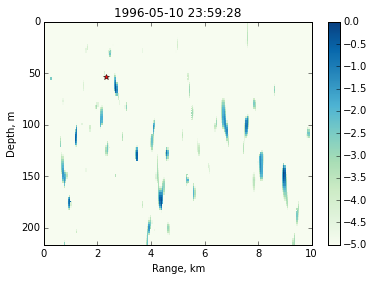

In [22]:
_ = plt.pcolormesh(R / 1e3, Z, B[tStamp].T, cmap = plt.cm.GnBu)
_ = plt.clim(-5, 0)
_ = plt.colorbar()
_ = plt.xlim(0, rMax / 1e3)
_ = plt.ylim(zMax,0)
_ = plt.title(str(t[tStamp]))
# _ = plt.title('Avg of freq =' + str(np.array(frequencies)[plotI]) +\
#               ' Hz, t = ' + K.iloc[0].index.name.strftime('J%j %H:%M:%S'))
_ = plt.plot(sRange[tStamp], 54, 'r*')
_ = plt.ylabel('Depth, m')
_ = plt.xlabel('Range, km')

In [20]:
np.savez('matchedFilterResult', B=B, R=R, Z=Z, t=t, f=f, wnGain=wnc_maxNorm, sRange = sRange)